In [550]:
import random
import numpy as np
from hmac import new
import matplotlib.pyplot as plt
from numpy import size
from typing import List, Tuple

In [551]:
class RandomSelector:
    def __init__(self):
        self.proba = []
        self.somme = 0

    def add(self, i):
        self.proba.append(float(i))
        self.somme += i

    def random_choice(self):
        rand = random.random() * self.somme
        cumul = 0
        for j in range(len(self.proba)):
            cumul += self.proba[j]
            if rand < cumul:
                return j
        return len(self.proba) - 1

In [552]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, generations: int, mutation_rate: float, elitist_rate: float, items: List[Tuple[int, List[int]]], budgets: List[int]):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elitist_rate = elitist_rate
        self.items = items
        self.budgets = budgets
        self.population = self.create_population(population_size, len(items))
 
    def create_population(self, size: int, n_items: int) -> List[List[int]]:
        # return [[random.randint(0, 1) for _ in range(n_items)] for _ in range(size)]
        population = []
        for _ in range(size):
            while True:
                solution = self.create_solution(n_items)
                total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
                if all(total_costs[j] <= self.budgets[j] for j in range(len(self.budgets))):
                    break
            population.append(solution)

        print(population)
        return population
    
    def create_solution(self, n_items: int) -> List[int]:
        return [random.randint(0, 1) for _ in range(n_items)]
    
 
    def fitness(self, solution: List[int]) -> int:
        total_utility = sum(solution[i] * self.items[i][0] for i in range(len(solution)))
        #total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
        return total_utility
 
    def selection(self) -> List[Tuple[List[int], List[int]]]:
        couples = []
        # total_fitness = sum(self.fitness(solution) for solution in self.population)
        # probabilities = [self.fitness(solution) / total_fitness for solution in self.population]
        selector = RandomSelector()
        fitnesses = [self.fitness(solution) for solution in self.population]
        for i in range(len(fitnesses)):
            selector.add(fitnesses[i])
        for _ in range(self.population_size // 2):
            mother = self.population[selector.random_choice()]
            father = self.population[selector.random_choice()]
            while mother == father:
                father = self.population[selector.random_choice()]
            couples.append((mother, father))
        return couples
 
    def crossover(self, parents: List[Tuple[List[int], List[int]]]) -> List[List[int]]:
        children =[]
        for parent in parents:
            child1 = []
            child2 = []
            for i in range(len(parent[0])):
                if random.uniform(0,1) < 0.5:
                    child1.append(parent[0][i])
                    child2.append(parent[1][i])
                else:
                    child1.append(parent[1][i])
                    child2.append(parent[0][i])
            children.append(child1)
            children.append(child2)
        return children
    
    def mutate(self, solution: List[int]) -> List[int]:
        index = random.randint(0, len(solution) - 1)
        if random.random() < self.mutation_rate:
                solution[index] = 1 - solution[index]
        return solution
 
    def mutate_variant1(self, solution: List[int]) -> List[int]:
        for i in range(len(solution)):
            if random.random() < self.mutation_rate:
                solution[i] = 1 - solution[i]
        return solution
 
    def repair(self, solution: List[int]) -> List[int]:
        total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
        ordered_items = sorted(range(len(solution)), key=lambda x: self.items[x][0], reverse=True)
        for i in ordered_items:
            if solution[i] == 1:
                for j in range(len(self.budgets)):
                    if total_costs[j] > self.budgets[j]:
                        solution[i] = 0
                        total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
                        break
        for i in reversed(ordered_items):
            if solution[i] == 0:
                if all(total_costs[j] + self.items[i][1][j] <= self.budgets[j] for j in range(len(self.budgets))):
                    solution[i] = 1
                    total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
        return solution
 
    def run(self) -> Tuple[List[int], int, List[int]]:
        generations_without_improvement = 0
        max_generations_without_improvement = 50
        best_fitness = 0
        best_solution = []
        for generation in range(self.generations):
            #print(generation + 1 , "th run")
            new_population = []
            couples = self.selection()
    
            children = self.crossover(couples)
            for child in children:
                new_population.append(self.repair(self.mutate(child)))

            if random.random() < self.elitist_rate:
                worst = min(new_population, key=self.fitness)
                best = max(self.population, key=self.fitness)
                new_population.remove(worst)
                new_population.append(best)
            
            self.population = new_population

            current_best_solution = max(self.population, key=self.fitness)
            current_best_value = self.fitness(current_best_solution)

            if current_best_value > best_fitness:
                best_fitness = current_best_value
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            if generations_without_improvement >= max_generations_without_improvement:
                print(f"Stopping early at generation {generation} due to no improvement")
                break

            #print("Best solution:" + str(current_best_solution))
            #print("Best value:" + str(current_best_value))
 
        best_solution = max(self.population, key=self.fitness)
        best_value = self.fitness(best_solution)
        best_costs = [sum(best_solution[i] * self.items[i][1][j] for i in range(len(best_solution))) for j in range(len(self.budgets))]
 
        return best_solution, best_value, best_costs

In [553]:
def multiple_runs(population_size: int, num_runs: int, generations: int, mutation_rate: float, elitist_rate: float, items: List[Tuple[int, List[int]]], budgets: List[int]):
    best_fitnesses = []
    for _ in range(num_runs):
        ga = GeneticAlgorithm(population_size, generations, mutation_rate, elitist_rate, items, budgets)
        best_solution, best_fitness, best_costs = ga.run()
        best_fitnesses.append(best_fitness)
    return best_fitnesses

[[1, 0, 1, 1], [0, 0, 1, 1], [0, 1, 0, 1], [1, 1, 0, 0], [0, 1, 1, 0], [0, 0, 1, 0], [1, 0, 1, 1], [1, 0, 0, 1], [1, 1, 0, 1], [0, 1, 1, 1], [0, 0, 1, 0], [1, 0, 1, 1], [1, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 0, 1], [0, 0, 0, 0], [1, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 1]]
[[0, 0, 1, 1], [1, 1, 1, 0], [0, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 1], [1, 1, 0, 1], [1, 0, 0, 0], [1, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 1, 1], [0, 0, 1, 0], [0, 0, 1, 0], [1, 1, 0, 0], [1, 0, 1, 1], [0, 1, 0, 0], [0, 1, 1, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]]
[[1, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 1], [0, 1, 1, 0], [1, 1, 0, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 1], [0, 1, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1], [1, 1, 1, 0], [0, 1, 1, 1], [0, 1, 1, 0], [1, 0, 1, 0], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 0], [0, 1, 1, 0]]
[[0, 0, 1, 0], [1, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 1], [1, 1, 1, 0], [1, 1, 0, 0], [0

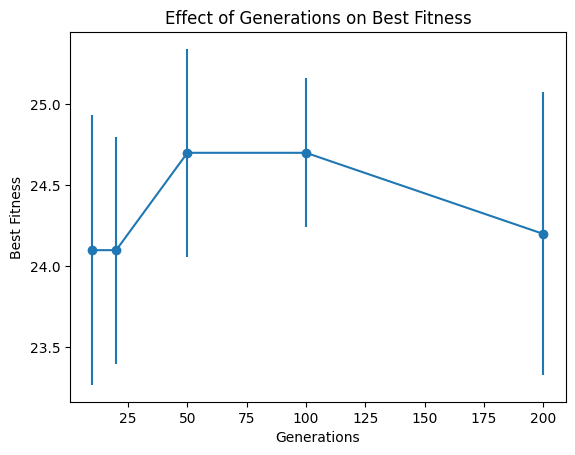

In [556]:


items = [
    (10, [5, 3]),
    (6, [4, 2]),
    (8, [6, 1]),
    (7, [3, 5])
]
budgets = [15, 10]
population_size = 20
mutation_rate = 0.1
elitist_rate = 0.1
num_runs = 10
generation_rounds = [10, 20, 50, 100, 200]

means = []
std_devs = []

for generations in generation_rounds:
    best_fitnesses = multiple_runs(population_size, num_runs, generations, mutation_rate, elitist_rate, items, budgets)
    mean = np.mean(best_fitnesses)
    std_dev = np.std(best_fitnesses)
    means.append(mean)
    std_devs.append(std_dev)
    print(f"Generations: {generations}, Mean: {mean}, Std Dev: {std_dev}")

plt.errorbar(generation_rounds, means, yerr=std_devs, fmt='-o')
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Effect of Generations on Best Fitness")
plt.show()